In [1]:

import os 
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

TOP_DIR = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())))
DATA_DIR = os.path.join(TOP_DIR, "data")
TRAIN_DIR = os.path.join(DATA_DIR, "training_data")

sys.path.append(os.path.join(TOP_DIR, "code"))

from utils import extract_filename_data, open_npy_file, open_y_data

In [2]:
def compute_img_datadata():
    npy_files = [f for f in os.listdir(TRAIN_DIR) if f.endswith(".npy")]
    file_data = list()
    for f in npy_files:
        data = extract_filename_data(f)
        data["fp"] = os.path.join(TRAIN_DIR, data["fn"])
        file_data.append(data)
    df = pd.DataFrame(file_data)
    
    h, w, p_max, p_min, p_mu = list(), list(), list(), list(), list()
    for fp in df["fp"]:
        arr = open_npy_file(fp)
        shape = arr.shape
        h.append(shape[0])
        w.append(shape[1])
        p_max.append(np.nanmax(arr))
        p_min.append(np.nanmin(arr))
        p_mu.append(np.nanmean(arr))
    df["h"] = h
    df["w"] = w
    df["p_max"] = p_max
    df["p_min"] = p_min
    df["p_mu"] = p_mu
    return df

recompute = False
img_fp = os.path.join(DATA_DIR, "training_images_metadata.csv")
if (not os.path.exists(img_fp)) or recompute:
    df = compute_img_datadata()
    df.to_csv(img_fp, encoding="utf-8", index=False)
else:
    df = pd.read_csv(img_fp, encoding="utf-8")
    df["date"] = pd.to_datetime(df["date"])
    df["streamgage"] = df["streamgage"].astype(str)
df.tail()

,fn,band,date,streamgage,fp,h,w,p_max,p_min,p_mu
55946,11318500__EPSG_4326__11131_95__ECMWF_ERA5_LAND...,total_precipitation,2013-04-30,11318500,/tf/toby/discharge-estimation/data/training_da...,2,5,0.000026,0.000026,0.000026
55947,11402000__EPSG_4326__11131_95__ECMWF_ERA5_LAND...,temperature_2m,2015-11-01,11402000,/tf/toby/discharge-estimation/data/training_da...,3,6,283.042053,281.566895,282.401093
55948,swe__11208000__2016_07_24.npy,swe,2016-07-24,11208000,/tf/toby/discharge-estimation/data/training_da...,208,158,1586.000000,0.000000,204.477209
55949,11208000__EPSG_4326__11131_95__ECMWF_ERA5_LAND...,temperature_2m,2013-04-05,11208000,/tf/toby/discharge-estimation/data/training_da...,2,3,282.003815,274.067139,277.732391
55950,11185500__EPSG_4326__11131_95__ECMWF_ERA5_LAND...,temperature_2m,2010-12-30,11185500,/tf/toby/discharge-estimation/data/training_da...,10,6,269.558777,255.099960,262.727570


In [3]:
df["streamgage"].value_counts()

11208000    7993
11185500    7993
11266500    7993
11318500    7993
11202710    7993
11402000    7993
11189500    7993
Name: streamgage, dtype: int64

In [4]:
df["band"].value_counts()

swe                    17899
total_precipitation    17899
temperature_2m         17899
et                      2254
Name: band, dtype: int64

In [5]:
df.dtypes

fn                    object
band                  object
date          datetime64[ns]
streamgage            object
fp                    object
h                      int64
w                      int64
p_max                float64
p_min                float64
p_mu                 float64
dtype: object

In [6]:
# Add in the outcome data:
y_df = open_y_data()
y_df = pd.pivot_table(y_df, index="date", columns="gage", values="m3", aggfunc=lambda x: x)
y_df.tail()

gage,11185500,11189500,11202710,11208000,11266500,11318500,11402000
date,,,,,,,
2018-09-26,1.217624,0.080986,0.622971,0.127426,0.563505,0.136204,0.654119
2018-09-27,1.217624,0.078721,0.594654,0.127426,0.555010,0.132240,0.645624
2018-09-28,1.217624,0.084667,0.594654,0.124594,0.543683,0.129691,0.591822
2018-09-29,1.217624,0.088349,0.622971,0.127426,0.535188,0.132240,0.492713
2018-09-30,0.566337,0.094578,0.622971,0.127426,0.532357,0.141867,0.521030


In [7]:
# Calculate the correlations with each data source and each lagging term:
p_max_df = pd.pivot_table(df, index=["band", "date"], columns="streamgage", 
                         values="p_max").sort_index()
p_min_df = pd.pivot_table(df, index=["band", "date"], columns="streamgage", 
                         values="p_min").sort_index()
p_mu_df = pd.pivot_table(df, index=["band", "date"], columns="streamgage", 
                         values="p_mu").sort_index()
p_mu_df.head()    

streamgage        11185500   11189500   11202710   11208000   11266500  \
band date                                                                
et   2010-01-01  11.913891  10.639462  30.168247  22.824667  29.471102   
     2010-01-09  20.638592  24.249428  39.853889  28.889553  21.605564   
     2010-01-17  13.151561  14.065636  29.869387  17.756098   0.000000   
     2010-01-25  33.002598  33.867928  58.892159  43.331799  20.072964   
     2010-02-02   9.564760  14.254467  12.037318   8.890014   6.379150   

streamgage        11318500   11402000  
band date                              
et   2010-01-01  51.613007   2.103193  
     2010-01-09  52.455986  24.477310  
     2010-01-17   0.000000   0.929076  
     2010-01-25  62.071770  19.725714  
     2010-02-02   7.160984  22.486387

In [8]:
def correlation_df(band: str, gage: str, 
                   lag: int = 0, agg: str = "mu"):
    pixel_df = {"mu": p_mu_df, "min": p_min_df, "max": p_max_df}[agg]
    y_series = y_df[gage]
    y_series.name = "y"
    img_series = pixel_df.loc[band, gage].shift(lag)
    img_series.name = "img_values"
    corr_df = pd.concat([y_series, img_series], axis=1).dropna()
    return corr_df 


correlation_df("temperature_2m", "11185500", lag=1, agg="mu").head()

,y,img_values
date,,
2010-01-02,0.0,271.534912
2010-01-03,0.0,271.610016
2010-01-04,0.0,272.364929
2010-01-05,0.0,273.267395
2010-01-06,0.0,272.505585


In [9]:
def compute_band_gage_correlation(band: str, gage: str, 
                                  lag: int = 0, agg: str = "mu"):
    corr_df = correlation_df(band, gage, lag=lag, agg=agg)
    return corr_df.corr().loc["y"].loc["img_values"]


compute_band_gage_correlation("temperature_2m", "11185500", lag=1, agg="mu")

0.004514091138853225

In [10]:
def compute_all_correlations(days: int = 365):
    correlations = list()
    freqs = {"et": 8, "swe": 1, "temperature_2m": 1, "total_precipitation": 1}
    for band, freq in freqs.items():
        print(band)
        max_lag = days // freq
        for lag in tqdm(range(max_lag)):
            for gage in p_mu_df.columns:
                for agg in ("mu", "min", "max"):
                    corr = compute_band_gage_correlation(band, gage, lag, agg)
                    corr_data = {"band": band, "gage": gage, "lag": lag,
                                 "agg": agg, "corr": corr}
                    correlations.append(corr_data)
    full_correlations = pd.DataFrame(correlations)
    return full_correlations


recompute = False
corr_fp = os.path.join(DATA_DIR, "img_correlations.csv")
if not (os.path.exists(corr_fp)) or recompute:
    all_corrs_df = compute_all_correlations()
    all_corrs_df.to_csv(corr_fp, encoding="utf-8", index=False)
else:
    all_corrs_df = pd.read_csv(corr_fp)
all_corrs_df.tail()

,band,gage,lag,agg,corr
23935,total_precipitation,11318500,364,min,0.071584
23936,total_precipitation,11318500,364,max,0.083550
23937,total_precipitation,11402000,364,mu,0.080432
23938,total_precipitation,11402000,364,min,0.071603
23939,total_precipitation,11402000,364,max,0.084434


In [11]:
def plot_correlation_lags(band: str, agg: str):
    subset = all_corrs_df[
        (all_corrs_df["band"] == band) & 
        (all_corrs_df["agg"] == agg)
    ].copy()
    fig, ax = plt.subplots(figsize=(10, 6))
    for gage in subset["gage"].unique():
        gage_subset = subset[subset["gage"] == gage].sort_values(by=["lag"])
        ax.plot(gage_subset["lag"], gage_subset["corr"], label=gage, alpha=0.5)
    all_gage_mu = subset.groupby(["lag"])["corr"].mean()
    ax.plot(all_gage_mu.index, all_gage_mu.values, label="All Gage Mean",
            color="#000000", linewidth=2, linestyle="--")
    ax.set_title(f"{band}, pixel {agg} lagging term correlations with discharge")
    ax.set_xlabel("Lagging Term")
    ax.set_ylabel("Correlation")
    ax.legend()
    return fig

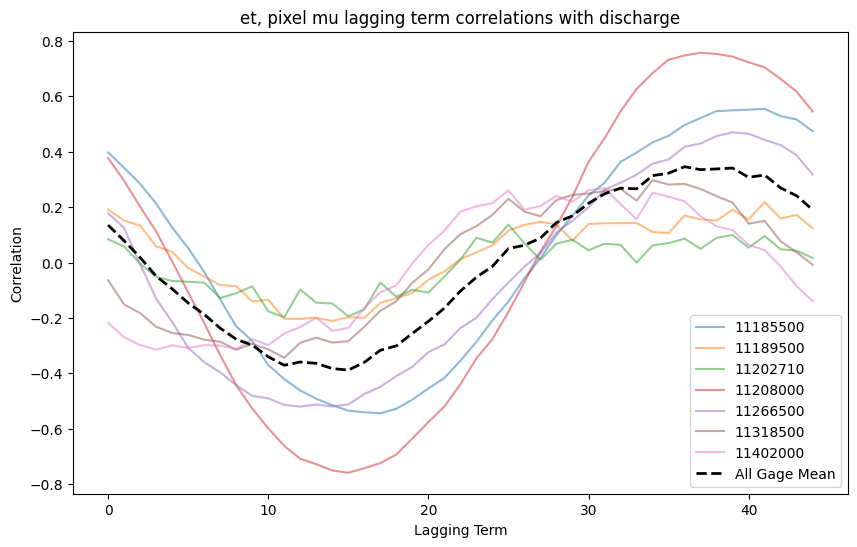

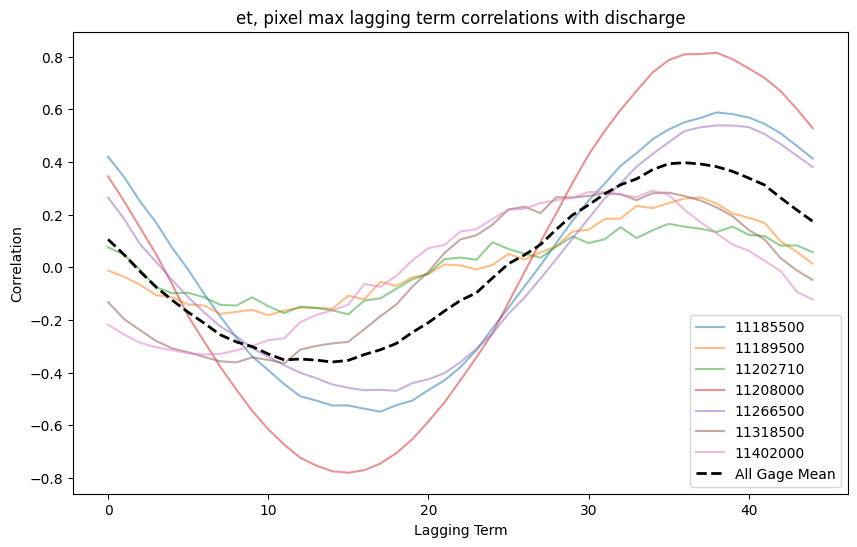

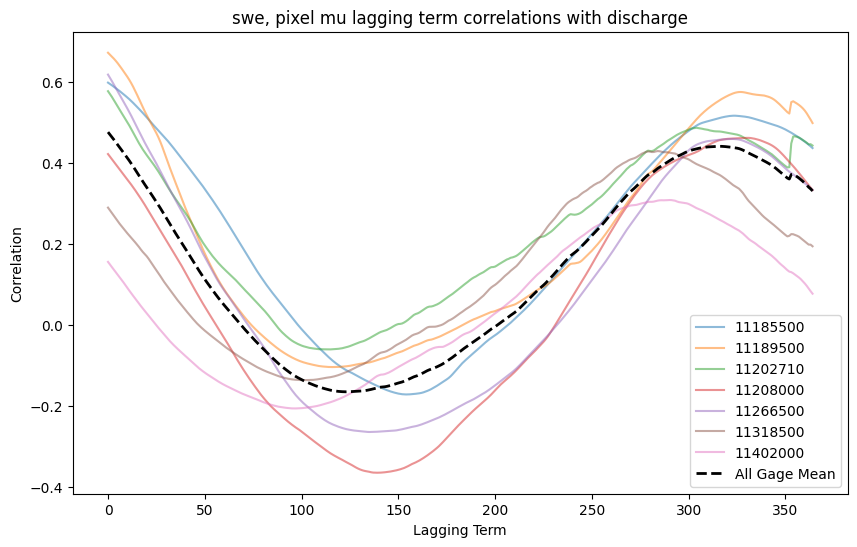

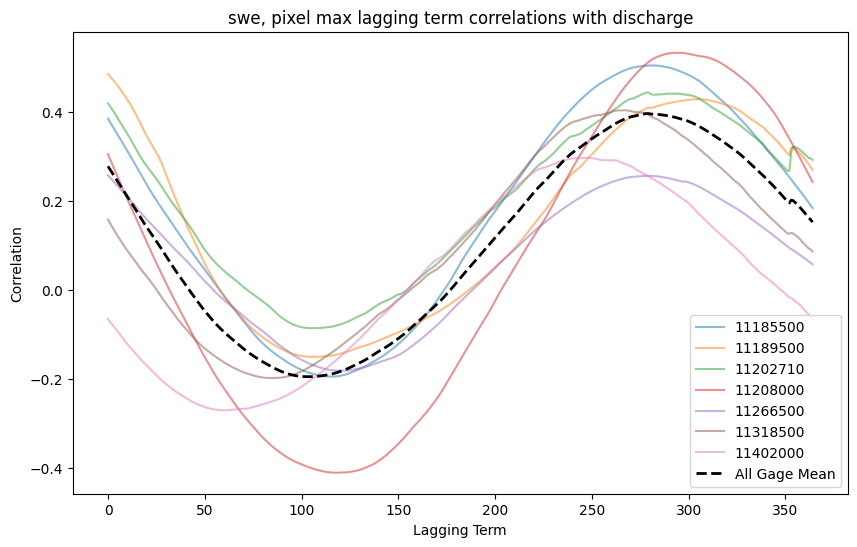

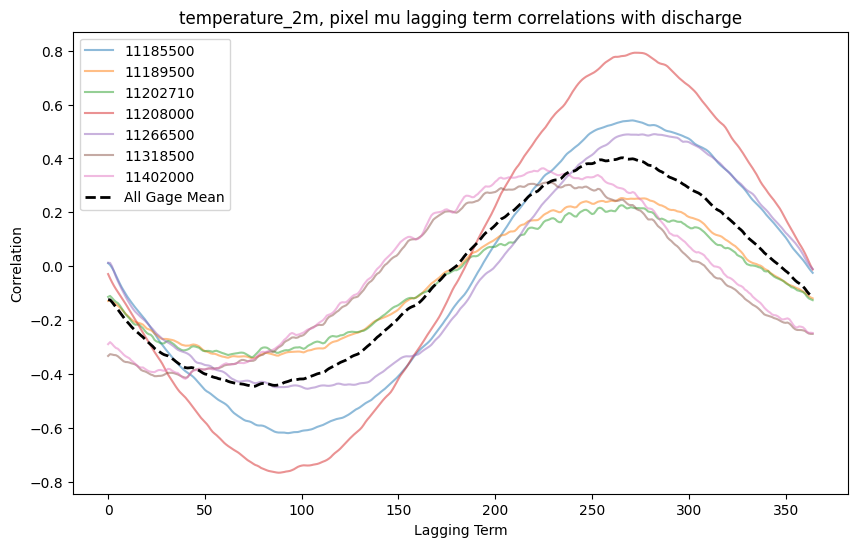

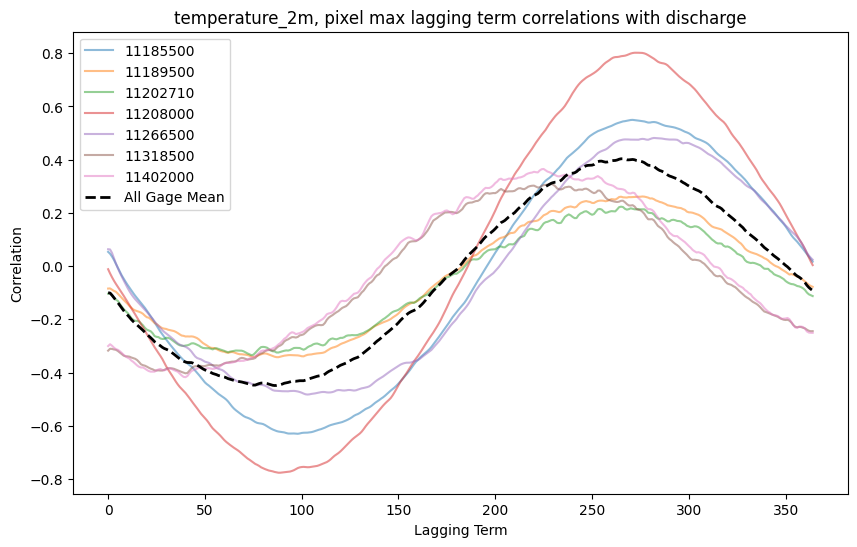

In [ ]:
for band in ("et", "swe", "temperature_2m", "total_precipitation"):
    for agg in ("mu", "max"):
        _ = plot_correlation_lags(band, agg)
        plt.show()